In [1]:
# installing dependencies
# !pip install tensorflow
# !pip install tensorflow_io

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import warnings
warnings.filterwarnings("ignore")

2024-02-20 23:38:12.899365: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 23:38:12.901285: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 23:38:12.926819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 23:38:12.926852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 23:38:12.927621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# read the excel file and load it into a Dataframe
DIR_EXCEL = os.path.join('..', 'data', 'VSD.xlsx')
df = pd.read_excel(DIR_EXCEL, sheet_name='read_dataset')
print(df.shape)
df.head(5)

(341, 5)


,File_segment_name,Duration,Violence_start,Violence_end,Violence_duration
0,angry_011,117.0,21.0,38.0,17.0
1,angry_011,117.0,40.0,55.0,15.0
2,angry_011,117.0,60.0,79.0,19.0
3,angry_011,117.0,85.0,95.0,10.0
4,angry_011,117.0,101.0,110.0,9.0


In [4]:
df['Violence_duration'].sum()

3050.9139999999998

In [5]:
# load all audio filenames into a list (discard redundant audios, example: angry_01.wav)
DIR_DATA = os.path.join('..', 'data', 'audios_VSD', 'audios_VSD')
redundant_audio_len = len('angry_01.wav')
filenames = [filename for filename in os.listdir(DIR_DATA) if len(filename) != redundant_audio_len]
print(len(filenames)) # how many audio files do we have (excluding redundant audios)
filenames[:5] + filenames[len(filenames)-5:] # print first 5 and last 5 filenames

110


['angry_011.wav',
 'angry_012.wav',
 'angry_013.wav',
 'angry_014.wav',
 'angry_015.wav',
 'angry_211.wav',
 'noviolence_01.wav',
 'noviolence_02.wav',
 'noviolence_03.wav',
 'noviolence_04.wav']

In [6]:
# let's divide toxic audio filenames and non-toxic audio filenames
toxic_filenames = filenames[:-4]
nontoxic_filenames = filenames[-4:]
print(toxic_filenames[-5:])
print(nontoxic_filenames)

['angry_203.wav', 'angry_204.wav', 'angry_205.wav', 'angry_206.wav', 'angry_211.wav']
['noviolence_01.wav', 'noviolence_02.wav', 'noviolence_03.wav', 'noviolence_04.wav']


In [7]:
EXAMPLE_FILENAME = filenames[0]
EXAMPLE_FILENAME

'angry_011.wav'

In [8]:
# function to get wave data from an audio file
SAMPLES_PER_SECOND = 16000
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=SAMPLES_PER_SECOND)
    return wav

In [9]:
# get wave from example audio file and plot it
wave = load_wav_16k_mono(os.path.join(DIR_DATA, EXAMPLE_FILENAME))
wave

2024-02-20 23:38:14.874960: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-02-20 23:38:14.931094: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


<tf.Tensor: shape=(1872000,), dtype=float32, numpy=
array([-1.5588116e-06,  4.4376916e-06, -4.4316839e-06, ...,
       -3.2952270e-01, -3.9674458e-01, -3.0953401e-01], dtype=float32)>

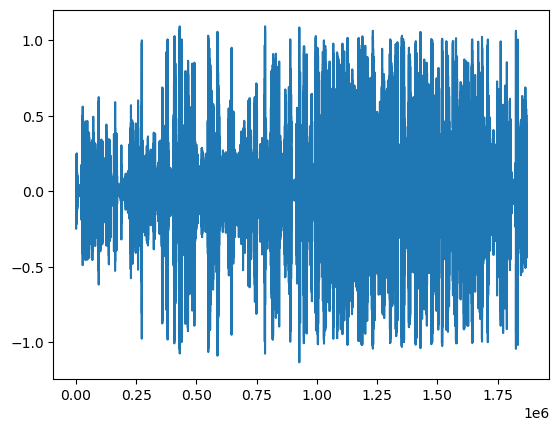

In [10]:
plt.plot(wave)
plt.show()

In [11]:
# get all waves from all audiofiles
waves = []
for filename in toxic_filenames:
    waves.append((filename, load_wav_16k_mono(os.path.join(DIR_DATA, filename))))
print(len(waves))

106


In [12]:
# let's slice the waves and retrieve ONLY the toxic segments
segments = []
audio_length = 0 # sum all segments length in seconds
for filename, wave in waves:
    sub_df = df[df['File_segment_name'] == filename[:-4]]
    for i in range(sub_df.shape[0]):
        start = sub_df.iloc[i][2]
        start_sample = int(start * SAMPLES_PER_SECOND) # calculate the start of the segment in sample index
        size = sub_df.iloc[i][4]
        size_sample = int(size * SAMPLES_PER_SECOND) # calculate the size of the segment in number of samples
        if start_sample + size_sample >= len(wave): # make sure that the start + size of the segment don't go outside audio boundries
            size_sample = len(wave) - start_sample
        if size_sample < 1 * SAMPLES_PER_SECOND: # exclude audio segments shorter than 1 second (excluding 27 segments)
            continue
        audio_length += size_sample # keep adding the segment length in seconds
        slice = tf.slice(wave, begin=[start_sample], size=[size_sample])
        segments.append((filename[:-4] + "_" + str(i), slice))
audio_length_secs = audio_length // SAMPLES_PER_SECOND
print(audio_length_secs, "seconds")
len(segments)

3044 seconds


310

In [13]:
# now that we have 3044 seconds of only toxic audio...
# let's join all segments, and slice them again in 10 second segments
# this will give us 304 equal length segments that we can use to train a model
segments_joined = tf.concat([segment[1] for segment in segments], 0)
# get rid of the last 4 seconds, just so we have exactly 3040 seconds
segments_joined = segments_joined[:SAMPLES_PER_SECOND * audio_length_secs]
segments_joined

<tf.Tensor: shape=(48704000,), dtype=float32, numpy=
array([-0.00717086, -0.00667315, -0.00130043, ..., -0.02748326,
       -0.04429958, -0.03331839], dtype=float32)>

In [14]:
# let's create the 10 second segments out of the 3040 sec of toxic audio only
SECONDS_PER_SEGMENT = 10
num_segments = audio_length_secs // SECONDS_PER_SEGMENT
SAMPLES_PER_SEGMENT = SECONDS_PER_SEGMENT * SAMPLES_PER_SECOND
new_segments = []
for i in range(num_segments):
    start_sample = i * SAMPLES_PER_SECOND
    new_segment = tf.slice(segments_joined, begin=[start_sample], size=[SAMPLES_PER_SEGMENT])
    new_segments.append(new_segment)
print(len(new_segments))
new_segments[:5]

304


[<tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([-0.00717086, -0.00667315, -0.00130043, ..., -0.01246491,
        -0.02152932, -0.03510552], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([-0.00289301,  0.03021058,  0.06220048, ...,  0.01427979,
         0.00470128, -0.01379599], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([-1.3426694e-02, -1.5097812e-02, -1.8019384e-02, ...,
        -1.0372097e-02,  3.7835867e-05,  1.3889559e-02], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([ 0.00511254, -0.01175897, -0.02543719, ...,  0.01161133,
        -0.00840763, -0.0119929 ], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([ 0.00732741,  0.00285657, -0.00698765, ..., -0.06338346,
        -0.1051461 , -0.12990886], dtype=float32)>]

In [15]:
# now that we have 304 TOXIC audio segments
# let's create 304 NON-TOXIC audio segments
# just so we have balanced data to train a model
nontoxic_waves = []
# due to the great length of non toxic audios we have to process them 1 by 1, outside a loop
filename = nontoxic_filenames[0:1][0]
nontoxic_waves.append((filename, load_wav_16k_mono(os.path.join(DIR_DATA, filename))))

In [16]:
# This audio contains too many zeroes. Let's skip it for now.
# due to the great length of non toxic audios we have to process them 1 by 1, outside a loop
# filename = nontoxic_filenames[1:2][0]
# nontoxic_waves.append((filename, load_wav_16k_mono(os.path.join(DIR_DATA, filename))))

In [17]:
# This audio is TOO LARGE, don't run this block
# due to the great length of non toxic audios we have to process them 1 by 1, outside a loop
# filename = nontoxic_filenames[2:3][0]
# nontoxic_waves.append((filename, load_wav_16k_mono(os.path.join(DIR_DATA, filename))))

In [18]:
# due to the great length of non toxic audios we have to process them 1 by 1, outside a loop
filename = nontoxic_filenames[3:4][0]
nontoxic_waves.append((filename, load_wav_16k_mono(os.path.join(DIR_DATA, filename))))

In [19]:
nontoxic_waves

[('noviolence_01.wav',
  <tf.Tensor: shape=(79023542,), dtype=float32, numpy=
  array([ 0.0000000e+00, -1.5518568e-10,  5.7849368e-11, ...,
          1.3298860e-03,  5.5263093e-04,  5.1844068e-04], dtype=float32)>),
 ('noviolence_04.wav',
  <tf.Tensor: shape=(59695856,), dtype=float32, numpy=
  array([ 0.        ,  0.        ,  0.        , ...,  0.00554482,
         -0.02701107, -0.03128438], dtype=float32)>)]

In [20]:
# let's randomnly create 304 segments from the loaded nontoxic audio files
import random
# let's define the segment starts and ensure that they don't overlap (we don't want redundant data for training)
starts = []
num_segments = 304
for i in range(num_segments):
    # first let's randomly select 1 out of the 3 nontoxic audio files
    new_audio_index = random.randint(0, len(nontoxic_waves)-1)
    current_size = len(starts)
    while current_size == len(starts):
        new_start = random.randint(0, len(nontoxic_waves[new_audio_index][1]))
        passed_validation = True
        for audio_index, start in starts:
            if new_audio_index != audio_index:
                continue
            if new_start >= start - SAMPLES_PER_SEGMENT and new_start <= start + SAMPLES_PER_SEGMENT:
                passed_validation = False
                break
            if new_start + SAMPLES_PER_SEGMENT >= len(nontoxic_waves[new_audio_index][1]):
                passed_validation = False
                break
        if passed_validation:
            starts.append((new_audio_index, new_start))
print(len(starts))
starts[:5]

304


[(1, 42439714), (0, 16491501), (0, 29060746), (0, 13600358), (0, 23827472)]

In [21]:
SAMPLES_PER_SEGMENT

160000

In [22]:
# now that we have the randomly generated starts of the non toxic audio segments
# let's actually go ahead and generate these segments based on the non overlapping starts
nontoxic_segments = []
for i, start in enumerate(starts):
    nontoxic_wave = nontoxic_waves[start[0]][1] # get the corresponding nontoxic audio tensor
    slice = tf.slice(nontoxic_wave, begin=[start[1]], size=[SAMPLES_PER_SEGMENT])
    nontoxic_segments.append(slice) # (nontoxic_waves[start[0]][0][:-4] + "_" + str(i),
print(len(nontoxic_segments))
nontoxic_segments[:5]

304


[<tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([ 0.03724594,  0.03804259,  0.04164317, ...,  0.00084975,
        -0.00115096, -0.00121317], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([-0.01415091, -0.01351208, -0.08192375, ..., -0.00840883,
         0.00607567, -0.00568069], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([-0.09857059, -0.09281269, -0.09375795, ..., -0.00931696,
        -0.01029179, -0.0046925 ], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([-0.02128833, -0.02228308, -0.0225965 , ..., -0.04452484,
        -0.03110448, -0.01466554], dtype=float32)>,
 <tf.Tensor: shape=(160000,), dtype=float32, numpy=
 array([ 1.0806185e-02,  1.6107699e-02,  1.3992631e-02, ...,
        -1.1816708e-03, -2.6568978e-03,  4.2064465e-05], dtype=float32)>]

In [23]:
# Now we finally have 304 TOXIC AUDIO FILES of 10 SECOND LENGTH and 304 NON-TOXIC AUDIO FILES of 10 second length as well
# They are both saved in the following variables:
toxic_segments = new_segments
print(len(toxic_segments)) # toxic segments
print(len(nontoxic_segments)) # non-toxic segments

304
304


In [24]:
# Failed: tried to convert segments back into audios
# file_contents = tf.io.read_file(os.path.join(DIR_DATA, toxic_filenames[0]))
# # Decode wav (tensors by channels) 
# wav, sample_rate_ = tf.audio.decode_wav(file_contents, desired_channels=1)
# sample_rate_
# tf.audio.encode_wav(wav, sample_rate=sample_rate_)

In [25]:
# let's convert our audio segments into spectograms, as these will be used to train the model
def convert_wav_into_spectrogram(wav, label):
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

# following function is discarded for now
def convert_wavs_into_spectrograms(wavs):
    # return [convert_wav_into_spectrogram(wav) for wav in wavs]
    spectrograms = []
    for i, wav in enumerate(wavs):
        print(i, end=", ")
        spectrograms.append(convert_wav_into_spectrogram(wav))
    return spectrograms

In [26]:
# toxic_spectrograms = convert_wavs_into_spectrograms(toxic_segments)

In [27]:
# nontoxic_spectrograms = convert_wavs_into_spectrograms(nontoxic_segments)

In [30]:
print(len(toxic_spectrograms))
print(len(nontoxic_spectrograms))

In [31]:
# now that we have the spectrograms, let's visualize a couple of them, 1 toxic and 1 non-toxic
# TOXIC SPECTROGRAM
plt.figure(figsize=(15,15))
plt.imshow(tf.transpose(toxic_spectrograms[32])[0])
plt.show()

In [ ]:
# NON-TOXIC SPECTROGRAM
plt.figure(figsize=(15,15))
plt.imshow(tf.transpose(nontoxic_spectrograms[32])[0])
plt.show()

In [ ]:
display(toxic_spectrograms[0].shape)
display(nontoxic_spectrograms[0].shape)

In [33]:
pos = tf.data.Dataset.from_tensor_slices(toxic_segments)
neg = tf.data.Dataset.from_tensor_slices(nontoxic_segments)
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
len(data)

608

In [34]:
wav, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
wav, label

(array([-0.02248843, -0.0230893 , -0.01703623, ...,  0.03062811,
         0.04080442,  0.03917713], dtype=float32),
 1.0)

In [35]:
spectrogram, label = convert_wav_into_spectrogram(wav, label)

In [36]:
data = data.map(convert_wav_into_spectrogram)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16) # creates 38 batches of 16 audio samples per batch = 608 audio samples
data = data.prefetch(8) # to avoid CPU bottlenecking

In [37]:
# let's calculate the number of batches for test and training
import math
print(len(data)) # 38 batches of 16 audio samples
train_num_batches = math.ceil(len(data)*0.7)
test_num_batches = math.floor(len(data)*0.3)
print(train_num_batches) # train number of batches
print(test_num_batches) # test number of batches

38
27
11


In [38]:
train = data.take(train_num_batches)
test = data.skip(train_num_batches).take(test_num_batches)

In [39]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 4991, 257, 1)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
def

In [49]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(4991, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())

In [ ]:
model.add(Dense(128, activation='relu'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [48]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 4989, 255, 16)     160       
                                                                 
 conv2d_12 (Conv2D)          (None, 4987, 253, 16)     2320      
                                                                 
 flatten_4 (Flatten)         (None, 20187376)          0         
                                                                 
Total params: 2480 (9.69 KB)
Trainable params: 2480 (9.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(4991, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])